In [1]:
import os, sys

HOMEDIR = os.path.expanduser("~")
PROJDIR = rf"{HOMEDIR}/G-scIB_dev"
sys.path.append(rf"{PROJDIR}/src")

import Data_Handler as dh, Utils_Handler as uh, Vis_Handler as vh
import umap, numpy as np, pandas as pd, scanpy as sc

sc.settings.set_figure_params(dpi=80, facecolor="white")
sc.settings.verbosity = 3

In [2]:
adata = sc.read_h5ad(dh.DATA_EMB_["lung"])
obsm_keys = list(adata.obsm)
for embed in obsm_keys:
    print("%12s, %d" % (embed, adata.obsm[embed].shape[1]))
    assert adata.obsm[embed].shape[0] == np.unique(adata.obsm[embed], axis=0).shape[0]

     Harmony, 50
    Islander, 16
   Scanorama, 100
     X_bbknn, 2
       X_pca, 50
    X_scANVI, 30
      X_scVI, 30
X_scanvi_emb, 30
      X_tsne, 2
      X_umap, 2
      scPoli, 10


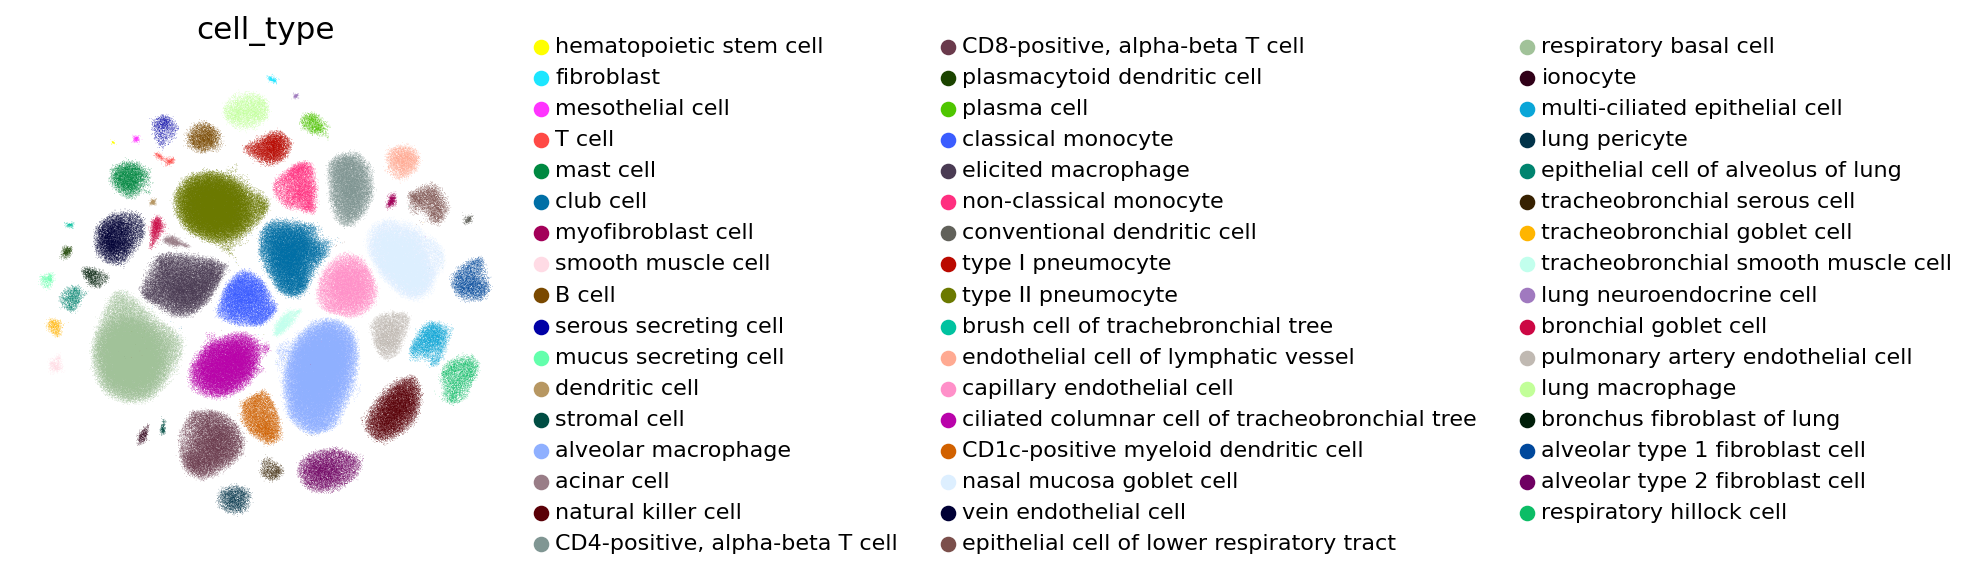

In [3]:
_obsm = "Islander"
dataset = "lung"
reducer = umap.UMAP(min_dist=1.0)
embedding = reducer.fit_transform(adata.obsm[_obsm])
adata.obsm["%s_UMAP" % _obsm] = embedding

sc.pl.embedding(
    adata,
    basis="%s_UMAP" % _obsm,
    color=[dh.META_[dataset]["celltype"]],  
    **vh.cfg
)

In [ ]:
adata.write(dh.DATA_EMB_[dataset], compression="gzip")

In [5]:
sc.pp.highly_variable_genes(adata, subset=True, flavor="seurat_v3", n_top_genes=1000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [6]:
adata

AnnData object with n_obs × n_vars = 542643 × 1000
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', 'o

In [7]:
adata.write(rf"{dh.DATA_DIR}/lung/emb_hvg.h5ad", compression="gzip")

### Process from the raw data

In [2]:
adata = sc.read_h5ad(dh.DATA_RAW_["lung"])
adata.var.index = adata.var["feature_name"].values.tolist()
adata.X = adata.raw.X
del adata.raw
# sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# sc.pp.log1p(adata)

""" to save subset of h5ad file """
# subset = adata.obs['sample'].unique()[:10]
# indices = [item in subset for item in adata.obs['sample']]
# adata._inplace_subset_obs(indices)
# adata.write(dh.DATA_RAW_["hlca_subset"], compression="gzip")

' to save subset of h5ad file '

In [3]:
adata

AnnData object with n_obs × n_vars = 584944 × 28024
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', '

In [4]:
import json
CELL2CAT = dict()
for idx, batch in enumerate(adata.obs["cell_type"].unique()):
    CELL2CAT[batch] = idx
_file = open(rf"{dh.META_DIR}/lung/cell2cat.json", "w")
_file.write(json.dumps(CELL2CAT))
_file.close()

BATCH2CAT = dict()
for idx, batch in enumerate(adata.obs["sample"].unique()):
    BATCH2CAT[batch] = idx
_file = open(rf"{dh.META_DIR}/lung/batch2cat.json", "w")
_file.write(json.dumps(BATCH2CAT))
_file.close()

In [5]:
adata = uh.preprocess(adata)

filtered out 39002 cells that have less than 1000 counts
filtered out 3299 cells that have less than 500 genes expressed
28024 genes x 542643 cells after quality control.
normalizing by total count per cell
    finished (0:00:06): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [6]:
adata.write(rf"{dh.DATA_DIR}/Lung/emb.h5ad", compression="gzip")

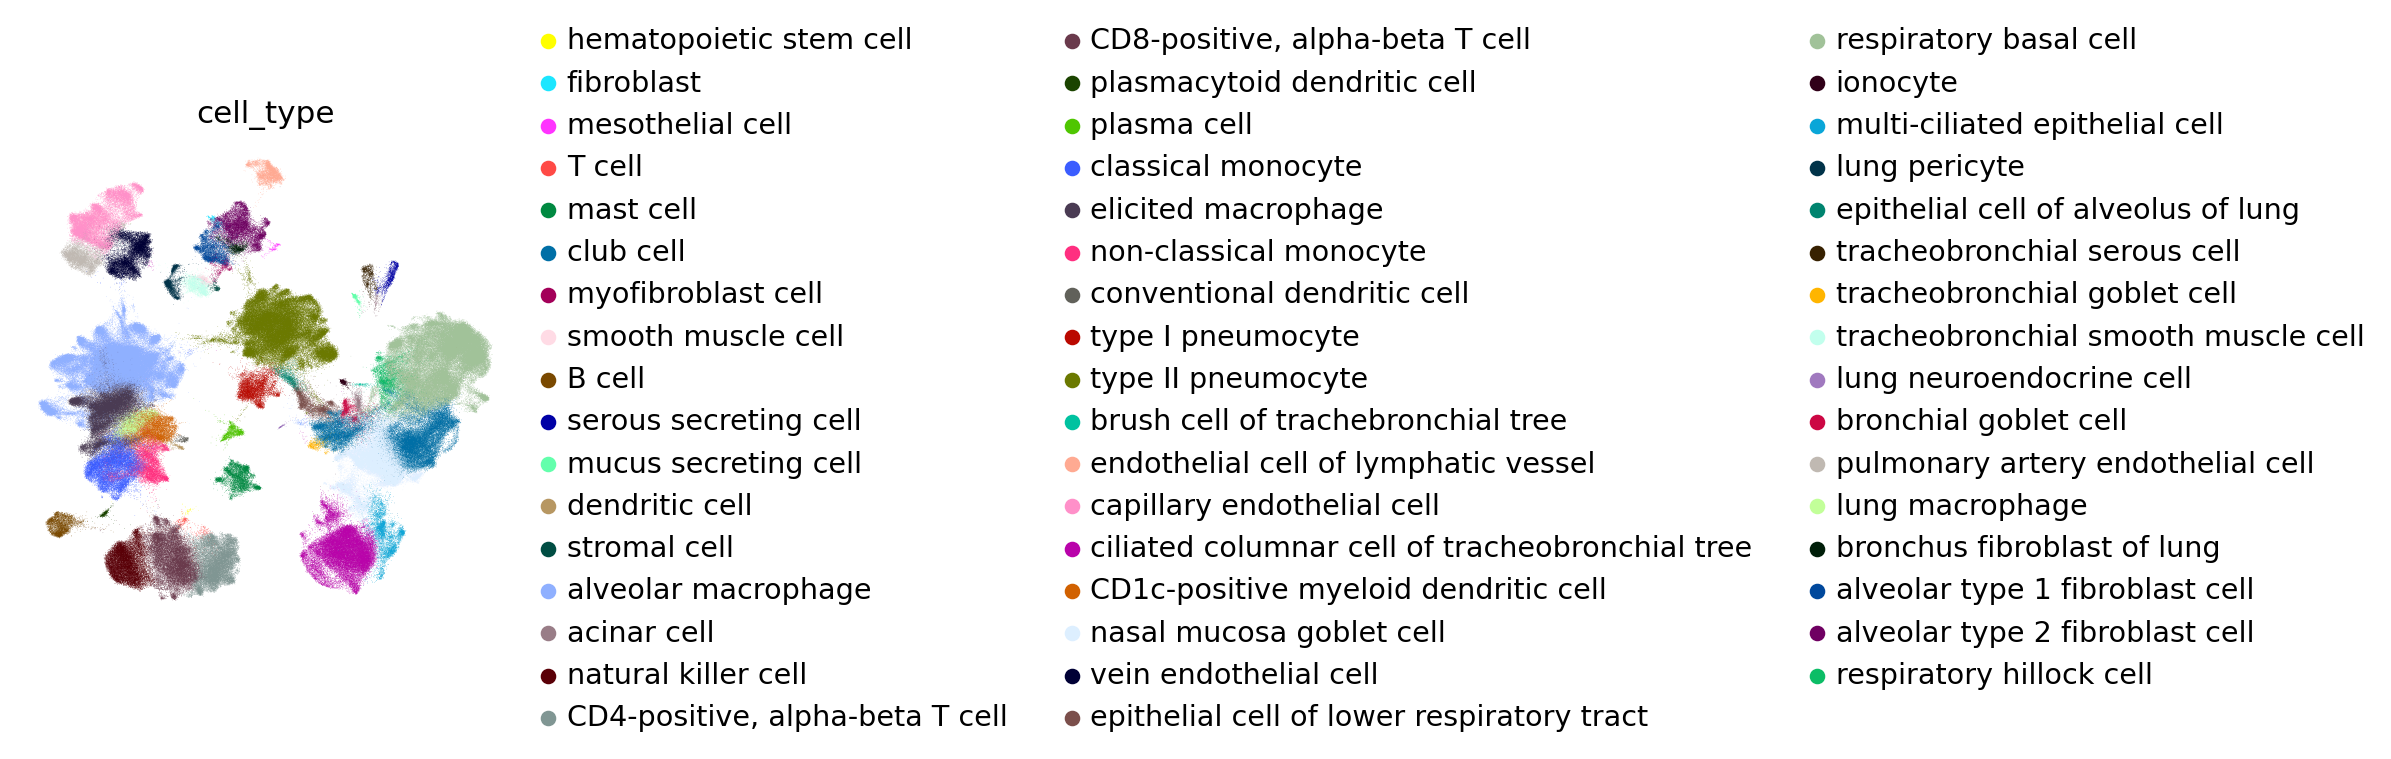

In [7]:
sc.pl.embedding(adata, basis="X_umap", color=["cell_type"], frameon=False, ncols=1)

In [39]:
adata = sc.read_h5ad("../data/local.h5ad")
adata.var.index = adata.var["feature_name"].values.tolist()
adata.raw = adata

In [40]:
for study in adata.obs["study"].unique():
    study_adata = adata[adata.obs["study"] == study]
    print("%25s" % study, study_adata.shape[0])

   Misharin_Budinger_2018 41216
             Krasnow_2020 60977
             Seibold_2020 33593
    Banovich_Kropski_2020 121881
              Nawijn_2021 70401
            Misharin_2021 64842
        Barbry_Leroy_2020 74486
     Teichmann_Meyer_2019 12229
      Lafyatis_Rojas_2019 24180
               Meyer_2019 35522
       Jain_Misharin_2021 45557


In [41]:
dispersion_df = pd.DataFrame(
    [], columns=adata.obs["study"].unique(), index=adata.var["feature_name"]
)

highly_var_df = dispersion_df.copy()

for study in adata.obs["study"].unique():
    study_adata = adata[adata.obs["study"] == study]
    sc.pp.normalize_total(study_adata, target_sum=1e4)
    sc.pp.log1p(study_adata)
    sc.pp.highly_variable_genes(study_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

    dispersion_df[study] = study_adata.var["dispersions"].fillna(0).values
    highly_var_df[study] = study_adata.var["highly_variable"].values

/home/hanchen/anaconda3/envs/genemetric/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/hanchen/anaconda3/envs/genemetric/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/hanchen/anaconda3/envs/genemetric/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/hanchen/anaconda3/envs/genemetric/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:01)
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/hanchen/anaconda3/envs/genemetric/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/hanchen/anaconda3/envs/genemetric/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/hanchen/anaconda3/envs/genemetric/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell


/home/hanchen/anaconda3/envs/genemetric/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell


/home/hanchen/anaconda3/envs/genemetric/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell


/home/hanchen/anaconda3/envs/genemetric/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/hanchen/anaconda3/envs/genemetric/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [42]:
dispersion_df

,Misharin_Budinger_2018,Krasnow_2020,Seibold_2020,Banovich_Kropski_2020,Nawijn_2021,Misharin_2021,Barbry_Leroy_2020,Teichmann_Meyer_2019,Lafyatis_Rojas_2019,Meyer_2019,Jain_Misharin_2021
feature_name,,,,,,,,,,,
TSPAN6,1.497357,1.630299,0.284777,2.101616,1.772096,1.563925,1.833386,1.129715,2.423610,1.864685,2.021171
TNMD,1.674243,1.303657,-0.301725,2.214566,2.379397,1.118059,2.063064,1.069420,1.748686,0.769934,1.906084
DPM1,1.355890,1.433577,0.028315,1.933730,2.066843,1.202982,1.786752,1.010920,2.121912,1.893968,2.048878
SCYL3,1.497143,1.697154,0.245784,2.029099,2.051942,1.490323,1.786028,1.225897,2.036653,2.078428,2.131616
C1orf112,1.433487,1.607745,0.081089,2.001366,2.132488,1.298656,1.927281,1.150829,2.454763,1.887639,2.151561
...,...,...,...,...,...,...,...,...,...,...,...
RP11-11M20.4,1.590490,1.758535,0.591150,1.826042,2.099092,1.811678,1.868946,1.308917,2.048775,2.211946,1.813826
LLNLR-245B6.1,1.418826,1.673805,0.143000,2.022497,2.063888,1.321499,1.889614,1.129714,2.129075,1.940337,1.999552
MGC4859,0.000000,0.000000,0.016689,0.000000,0.759313,0.538970,1.853648,0.530774,0.000000,2.162390,1.907530


    Top 10 Genes that vary among various studies in the dispersion values

In [43]:
dispersion_df.var(axis=1).sort_values(ascending=False)[:10]

feature_name
PRB4             2.317738
IGHV3-73         2.217823
IGLV9-49         2.140298
RP11-332H18.7    2.108293
IGLV2-18         2.102015
TRAV12-2         2.085048
LINC01903        2.048952
PRB2             2.047593
IGHGP            2.036701
LINC02086        1.984144
dtype: float64

    Top 10 Genes that have highest average values among various studies

In [44]:
dispersion_df.mean(axis=1).sort_values(ascending=False)[:10]

feature_name
TPSAB1    2.956654
TPSB2     2.882648
JCHAIN    2.739720
IGHA2     2.673165
DCN       2.666008
CPA3      2.640537
IGLC2     2.640486
IGLC3     2.640449
ACKR1     2.631320
IGHG2     2.618494
dtype: float64

    The expression level of genes are quite different

In [45]:
import seaborn as sns

sns.set()

    Correlation matrix for dispersion values of genes

<AxesSubplot: >

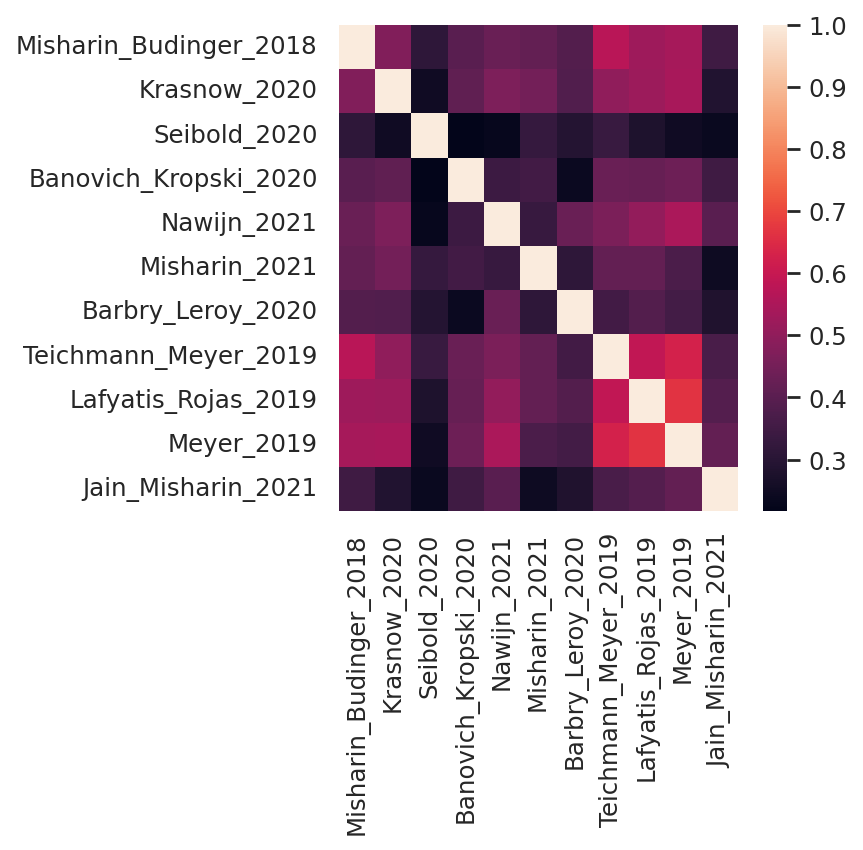

In [46]:
corr = dispersion_df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)